# Wczytanie danych oraz bibliotek

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt

In [13]:
data = pd.read_csv("../data/to_model/new_york_listings_2024_to_model.csv");
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,718037328155265207,Rental unit in Queens · 5 bedrooms · 8 beds · ...,204539,Mark,Queens,Ridgewood,40.70262,-73.89800,Entire home/apt,471.0,...,2022-11-03,0.07,9,365,0,No License,No rating,5,8,2
1,5536638,Rental unit in Brooklyn · ★4.60 · 2 bedrooms ·...,28709982,Sidiq,Brooklyn,Williamsburg,40.72027,-73.95513,Entire home/apt,225.0,...,2023-09-13,0.49,5,90,7,No License,4.60,2,2,1
2,4605840,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,23788242,Suzanne,Brooklyn,Bedford-Stuyvesant,40.68670,-73.94856,Private room,80.0,...,2023-11-17,1.00,2,363,12,No License,4.93,1,1,1
3,594240338554500815,Rental unit in New York · 1 bedroom · 1 bed · ...,384559808,Best Inns USA,Manhattan,East Village,40.73221,-73.98689,Entire home/apt,83.0,...,2023-08-11,0.12,30,106,1,No License,No rating,1,1,1
4,26785,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,42273,Dani,Brooklyn,South Slope,40.66860,-73.98723,Entire home/apt,90.0,...,2022-05-31,2.90,3,188,0,No License,4.93,1,1,1


# Przygotowanie danych
- usuwamy kolumny: id, host_id, host_name, name, neighbourhood_group, neighbourhood, number_of_reviews_ltm (zostawiamy rewievs_per_month), bedrooms (zostawiamy beds)
- mapujemy kolumnę 
        - 'license' na 0 i 1 (0 - brak licencji, 1 - licencja)
        - 'baths' na int (jeśli nie jest podana to 0)
        - 'bedrooms' na int (jeśli nie jest podana to 0, a jeśli jest studio to 1)
        - 'rating' na float (jeśli nie ma to NaN)
- ordinal encoding dla 'room_type'
- kodujmey date 'last_review'
- uzywamy regresji linowej zeby uzupelnic NA w ratingu

### mapujemy

In [14]:
def lic_mapper(a):
    if a == "No License" or a == "Exempt":
        return 0
    else:
        return 1

def bath_mapper(a):
    if a == "Not specified":
        return 0
    else:
        return int(float(a))
def bedroom_mapper(a): # Uznałem, że posiadanie studio (czyli całe mieszkanie w jednym większym pokoju) to tak jakby była jedna sypialnia
    if a == "Studio":
        return 1
    else:
        return int(a)
def rating_mapper(a): # na razie tak może zostać
    if a == "New " or a == "No rating":
        return np.nan
    else:
        return float(a)
data["license"] = data["license"].map(lic_mapper)  # Jeśli ma licencję to 1, jeśli nie to 0
data["baths"] = data["baths"].map(bath_mapper)
data["bedrooms"] = data["bedrooms"].map(bedroom_mapper)
data["rating"] = data["rating"].map(rating_mapper)
data["last_review"] =  data["last_review"].map(np.datetime64) # Zmapowałem też date ostatniej opinii do przeznaczonego do tego typu

data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,718037328155265207,Rental unit in Queens · 5 bedrooms · 8 beds · ...,204539,Mark,Queens,Ridgewood,40.702620,-73.898000,Entire home/apt,471.0,...,2022-11-03,0.07,9,365,0,0,NaN,5,8,2
1,5536638,Rental unit in Brooklyn · ★4.60 · 2 bedrooms ·...,28709982,Sidiq,Brooklyn,Williamsburg,40.720270,-73.955130,Entire home/apt,225.0,...,2023-09-13,0.49,5,90,7,0,4.60,2,2,1
2,4605840,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,23788242,Suzanne,Brooklyn,Bedford-Stuyvesant,40.686700,-73.948560,Private room,80.0,...,2023-11-17,1.00,2,363,12,0,4.93,1,1,1
3,594240338554500815,Rental unit in New York · 1 bedroom · 1 bed · ...,384559808,Best Inns USA,Manhattan,East Village,40.732210,-73.986890,Entire home/apt,83.0,...,2023-08-11,0.12,30,106,1,0,NaN,1,1,1
4,26785,Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...,42273,Dani,Brooklyn,South Slope,40.668600,-73.987230,Entire home/apt,90.0,...,2022-05-31,2.90,3,188,0,0,4.93,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,726891322486149349,Condo in Brooklyn · ★4.87 · 3 bedrooms · 3 bed...,478704134,Milosz,Brooklyn,Bedford-Stuyvesant,40.686001,-73.943693,Entire home/apt,135.0,...,2023-01-10,0.97,1,262,1,0,4.87,3,3,1
16602,51828187,Home in Queens · ★4.69 · 1 bedroom · 1 bed · 1...,419863661,Yessica,Queens,Corona,40.745100,-73.864880,Private room,68.0,...,2023-10-16,2.68,2,180,16,0,4.69,1,1,1
16603,746852890077275772,Rental unit in The Bronx · ★4.73 · 1 bedroom ·...,471441645,Dyar,Bronx,Allerton,40.867770,-73.860180,Entire home/apt,100.0,...,2023-10-07,2.21,5,365,24,0,4.73,1,1,1
16604,14822309,Rental unit in New York · ★4.84 · 1 bedroom · ...,16978120,Chip,Manhattan,Harlem,40.830791,-73.949509,Private room,50.0,...,2023-12-10,0.21,4,42,1,0,4.84,1,1,1


### usuwamy kolumny

In [15]:
data = data.drop(["id", "name", "host_id", "host_name", "neighbourhood", "neighbourhood_group", "number_of_reviews_ltm", "bedrooms"], axis = 1)
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,Entire home/apt,471.0,30,1,2022-11-03,0.07,9,365,0,NaN,8,2
1,40.720270,-73.955130,Entire home/apt,225.0,30,52,2023-09-13,0.49,5,90,0,4.60,2,1
2,40.686700,-73.948560,Private room,80.0,30,101,2023-11-17,1.00,2,363,0,4.93,1,1
3,40.732210,-73.986890,Entire home/apt,83.0,30,2,2023-08-11,0.12,30,106,0,NaN,1,1
4,40.668600,-73.987230,Entire home/apt,90.0,30,479,2022-05-31,2.90,3,188,0,4.93,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,Entire home/apt,135.0,30,15,2023-01-10,0.97,1,262,0,4.87,3,1
16602,40.745100,-73.864880,Private room,68.0,30,16,2023-10-16,2.68,2,180,0,4.69,1,1
16603,40.867770,-73.860180,Entire home/apt,100.0,30,30,2023-10-07,2.21,5,365,0,4.73,1,1
16604,40.830791,-73.949509,Private room,50.0,30,19,2023-12-10,0.21,4,42,0,4.84,1,1


### ordinal encoding dla 'room_type'

In [16]:
room_type_map = {
    'Entire home/apt' : 3,
    "Hotel room": 2,
    "Private room": 1,
    "Shared room": 0
}
data["room_type"] = data["room_type"].map(room_type_map)
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,2022-11-03,0.07,9,365,0,NaN,8,2
1,40.720270,-73.955130,3,225.0,30,52,2023-09-13,0.49,5,90,0,4.60,2,1
2,40.686700,-73.948560,1,80.0,30,101,2023-11-17,1.00,2,363,0,4.93,1,1
3,40.732210,-73.986890,3,83.0,30,2,2023-08-11,0.12,30,106,0,NaN,1,1
4,40.668600,-73.987230,3,90.0,30,479,2022-05-31,2.90,3,188,0,4.93,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,3,135.0,30,15,2023-01-10,0.97,1,262,0,4.87,3,1
16602,40.745100,-73.864880,1,68.0,30,16,2023-10-16,2.68,2,180,0,4.69,1,1
16603,40.867770,-73.860180,3,100.0,30,30,2023-10-07,2.21,5,365,0,4.73,1,1
16604,40.830791,-73.949509,1,50.0,30,19,2023-12-10,0.21,4,42,0,4.84,1,1


### Kodowanie daty 'last_review'

In [17]:
new_review = data["last_review"].apply(lambda x: x.timestamp())
a = new_review.min()
b = new_review.max()
new_review = new_review.apply(lambda x: (x - a) / (b - a))
data["last_review"] = new_review
data

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,NaN,8,2
1,40.720270,-73.955130,3,225.0,30,52,0.973081,0.49,5,90,0,4.60,2,1
2,40.686700,-73.948560,1,80.0,30,101,0.988430,1.00,2,363,0,4.93,1,1
3,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,NaN,1,1
4,40.668600,-73.987230,3,90.0,30,479,0.862102,2.90,3,188,0,4.93,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.87,3,1
16602,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.69,1,1
16603,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.73,1,1
16604,40.830791,-73.949509,1,50.0,30,19,0.993861,0.21,4,42,0,4.84,1,1


### inputacja nanow w ratingu

In [18]:
from sklearn.linear_model import LinearRegression
df_to_pred = data.copy()
# Te dane będziemy musieli uzupełnic
to_fill = df_to_pred[df_to_pred['rating'].isna()]
# Na tych danych wyszkolimy nasz LinearRegression model
filled = data[df_to_pred.index.map(lambda x: x not in to_fill.index.to_numpy()).to_numpy()]
#
to_fill = to_fill.reset_index(drop = True)
filled = filled.reset_index(drop = True)
# Szkolimy model regresji liniowej
X = filled.drop("rating", axis = 1)
y = filled["rating"]
lr = LinearRegression()
lr.fit(X, y)
new_rating = lr.predict(to_fill.drop("rating", axis = 1))
pd.Series(new_rating)
# Wypełniamy nany
to_fill["rating"] = new_rating

In [19]:
#sprawdzamy
to_fill['rating'].isna().sum()

0

In [20]:
# Pozostaje zatem przepisac ramke jako nowa df
df = pd.concat([to_fill, filled], axis = 0).reset_index(drop = True)
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,4.678690,8,2
1,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,4.742355,1,1
2,40.684210,-73.907890,1,150.0,30,1,0.594097,0.02,1,0,0,4.670132,1,1
3,40.874690,-73.901690,1,200.0,30,1,0.481700,0.01,2,0,0,4.593371,1,1
4,40.671320,-73.960900,1,32.0,30,1,0.783707,0.03,1,322,0,4.679929,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,55.0,30,3,0.983943,0.21,1,364,0,5.000000,1,1
16602,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.870000,3,1
16603,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.690000,1,1
16604,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.730000,1,1


## transforamcje danych
Ostatecznie:
- uzywamy PYOD do usuniecia outlierow 
- uzywami yeo-johnson (oprocz latitude, longitude, room_type, license) i pozniej min_max_scaler

### Usuwanie outlierów

In [21]:
# oprocz latitude, longtitude, room_type (kategoryczna), license (binarna)
cols = df.columns.to_numpy()
cols_to_pyod = [cols for cols in df.columns if cols not in ["latitude", "longitude", "room_type", "license"]]

from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
clf.fit(df[cols_to_pyod])
df['outliers'] = clf.labels_
df['outliers'].value_counts()

outliers
0    15941
1      665
Name: count, dtype: int64

In [22]:
# usuwamy outliery
df = df[df['outliers'] == 0]
df = df.drop('outliers', axis = 1)
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,471.0,30,1,0.898937,0.07,9,365,0,4.678690,8,2
1,40.732210,-73.986890,3,83.0,30,2,0.965289,0.12,30,106,0,4.742355,1,1
2,40.684210,-73.907890,1,150.0,30,1,0.594097,0.02,1,0,0,4.670132,1,1
3,40.874690,-73.901690,1,200.0,30,1,0.481700,0.01,2,0,0,4.593371,1,1
4,40.671320,-73.960900,1,32.0,30,1,0.783707,0.03,1,322,0,4.679929,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,55.0,30,3,0.983943,0.21,1,364,0,5.000000,1,1
16602,40.686001,-73.943693,3,135.0,30,15,0.914994,0.97,1,262,0,4.870000,3,1
16603,40.745100,-73.864880,1,68.0,30,16,0.980874,2.68,2,180,0,4.690000,1,1
16604,40.867770,-73.860180,3,100.0,30,30,0.978749,2.21,5,365,0,4.730000,1,1


### yeo-johnson
bez latitude, longitude, room_type, license

In [23]:
cols_to_johnson = [cols for cols in df.columns if cols not in ["latitude", "longitude", "room_type", "license"]]

from scipy.stats import yeojohnson
# korzystanie z yeo_johhsona
df_yeo = df.copy()
for col in cols_to_johnson:
    df_yeo[col], _ = yeojohnson(df[col])
df_yeo

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,40.702620,-73.898000,3,4.349581,9.727349,0.677335,89664.099417,0.065720,1.038272,55.411318,0,2.761742e+08,0.382909,0.628101
1,40.732210,-73.986890,3,3.434738,9.727349,1.059243,195177.092109,0.107960,1.151104,25.683720,0,3.180145e+08,0.320938,0.480012
2,40.684210,-73.907890,1,3.767077,9.727349,0.677335,1703.996897,0.019634,0.529391,0.000000,0,2.709542e+08,0.320938,0.480012
3,40.874690,-73.901690,1,3.920853,9.727349,0.677335,325.278516,0.009908,0.725473,0.000000,0,2.280323e+08,0.320938,0.480012
4,40.671320,-73.960900,1,2.854393,9.727349,0.677335,21721.564540,0.029185,0.529391,51.299637,0,2.769376e+08,0.320938,0.480012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,40.745330,-73.919580,1,3.190871,9.727349,1.324002,241739.557378,0.175758,0.529391,55.317979,0,5.541467e+08,0.320938,0.480012
16602,40.686001,-73.943693,3,3.709492,9.727349,2.530828,108501.726723,0.513213,0.529391,45.172859,0,4.200070e+08,0.373762,0.480012
16603,40.745100,-73.864880,1,3.317912,9.727349,2.581095,233408.940046,0.782119,0.725473,35.790661,0,2.832152e+08,0.320938,0.480012
16604,40.867770,-73.860180,3,3.541716,9.727349,3.068367,227803.107791,0.735039,0.941464,55.411318,0,3.094645e+08,0.320938,0.480012


In [67]:
# ZAPISUJE DLA POZNIEJSZEGO UZYCIA W MAPKACH
lat_max = df_yeo['latitude'].max()
lat_min = df_yeo['latitude'].min()
long_max = df_yeo['longitude'].max()
long_min = df_yeo['longitude'].min()

### min_max_scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler

# WSZYSTKIE kolumny
df_final = df_yeo.copy()
scaler = MinMaxScaler()
df_final[df_final.columns] = scaler.fit_transform(df_final[df_final.columns])
df_final

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths
0,0.492428,0.656185,1.000000,0.758784,0.126667,0.000000,0.309020,0.051765,0.737167,1.000000,0.0,0.498299,0.985259,0.757568
1,0.564453,0.490405,1.000000,0.452508,0.126667,0.086282,0.672663,0.090941,0.900616,0.463510,0.0,0.573815,0.000000,0.578954
2,0.447617,0.637740,0.333333,0.563770,0.126667,0.000000,0.005873,0.009021,0.000000,0.000000,0.0,0.488878,0.000000,0.578954
3,0.911261,0.649303,0.333333,0.615252,0.126667,0.000000,0.001121,0.000000,0.284046,0.000000,0.0,0.411410,0.000000,0.578954
4,0.416242,0.538876,0.333333,0.258218,0.126667,0.000000,0.074862,0.017879,0.000000,0.925797,0.0,0.499677,0.000000,0.578954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16601,0.596388,0.615938,0.333333,0.370865,0.126667,0.146097,0.833137,0.153823,0.000000,0.998316,0.0,1.000000,0.000000,0.578954
16602,0.451976,0.570967,1.000000,0.544492,0.126667,0.418746,0.373943,0.466805,0.000000,0.815228,0.0,0.757897,0.839836,0.578954
16603,0.595828,0.717954,0.333333,0.413397,0.126667,0.430102,0.804426,0.716210,0.284046,0.645909,0.0,0.511007,0.000000,0.578954
16604,0.894417,0.726720,1.000000,0.488323,0.126667,0.540188,0.785106,0.672544,0.596931,1.000000,0.0,0.558384,0.000000,0.578954


ostateczna nazwa danych po wszytski transformacjach to df_final

# Modele

## 1. K-means

In [35]:
from sklearn.cluster import KMeans

In [36]:
seed = 17

In [37]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state = seed)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

### 1.1 Wskaznik Silhouette

In [38]:
from sklearn.metrics import silhouette_score

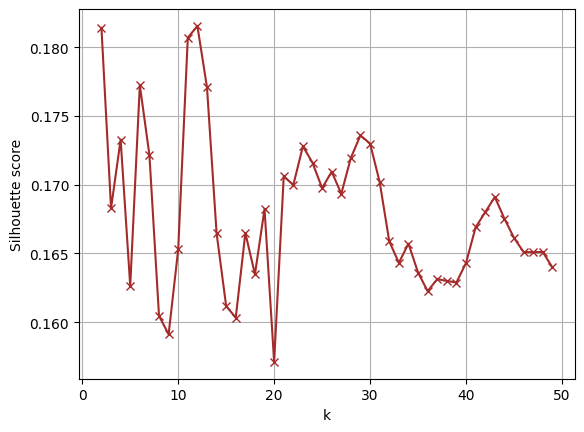

In [39]:
cluster_num_seq = range(2, 50)
silhouette_vec = count_clustering_scores(df_final, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

Tu najlepiej sprawdza się 29 klastrów (jeśli chcemy mieć dużo klastrów co wydaje się sensowne w naszej rekomendajcji) lub 12 klastrów (Jesli brać pod uwagę sama metrykę, ale to może być za mało klastrów z perspektywy problemu)

### 1.2 Calinski Harabash score

In [40]:
from sklearn.metrics import calinski_harabasz_score

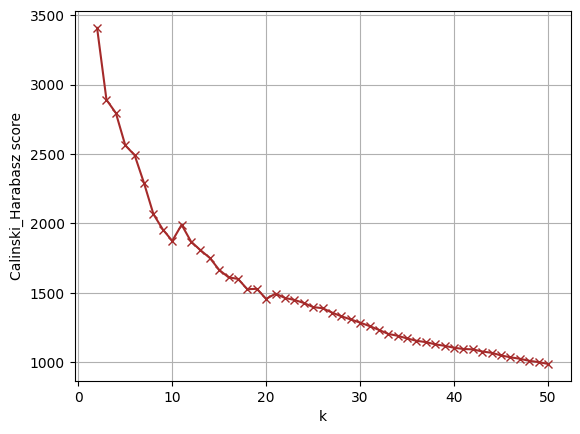

In [44]:
cluster_num_seq = range(2, 51)
calinski_vec = count_clustering_scores(df_final, cluster_num_seq, KMeans, calinski_harabasz_score)
plt.plot(cluster_num_seq, calinski_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Calinski_Harabasz score')
plt.grid()
plt.show()

Tutaj nie dostajemy zadowalającej metryki tam gdzie chcemy (2 klastry nie podlegają pod nasz problem rekomendacji)

### 1.4 Davies Bouldin score

In [42]:
from sklearn.metrics import davies_bouldin_score

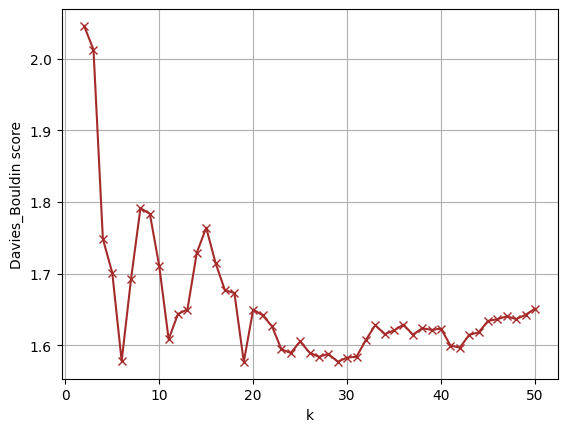

In [45]:
cluster_num_seq = range(2, 51)
davies_vec = count_clustering_scores(df_final, cluster_num_seq, KMeans, davies_bouldin_score)
plt.plot(cluster_num_seq, davies_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.grid()
plt.show()

Tutaj najlepiej sprawdza się 19 klastrów co jest już sensowne w przypadku naszego problemu rekomendacji

### 1.5 Czy wyniki są lepsze dla innego algorithmu kmeans?

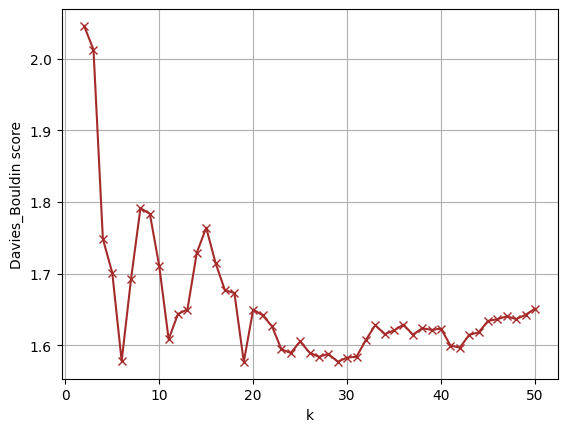

In [48]:
scores = []    
for k in range(2, 51):
    model_instance = KMeans(n_clusters=k, random_state = seed, algorithm = "elkan")
    labels = model_instance.fit_predict(df_final)
    wcss = davies_bouldin_score(df_final, labels)
    scores.append(wcss)
plt.plot(cluster_num_seq, scores, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.grid()
plt.show()

Jak widać wyniki sa takie same (różnica między algorytmami jest tylko w szybkości wykonywania się)

### 1.6 Wizualizacja

#### PCA

Ze wskaźników wyniknęło, że najlepsza liczba klastrów to: 12, 19, 29

In [49]:
from sklearn.decomposition import PCA

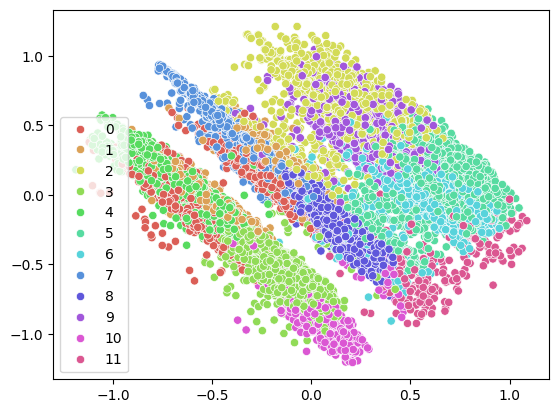

In [53]:
# Dla 12
pca = PCA()
kmeans = KMeans(n_clusters=12, random_state = seed)
result = pca.fit_transform(df_final)
labels = kmeans.fit_predict(df_final)
sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = labels, palette=sns.color_palette("hls", 12))
plt.show()

C:\Users\Bartek\AppData\Local\Temp\ipykernel_6108\4294119652.py:6: UserWarning: 
The palette list has fewer values (12) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = labels, palette=sns.color_palette("hls", 12))


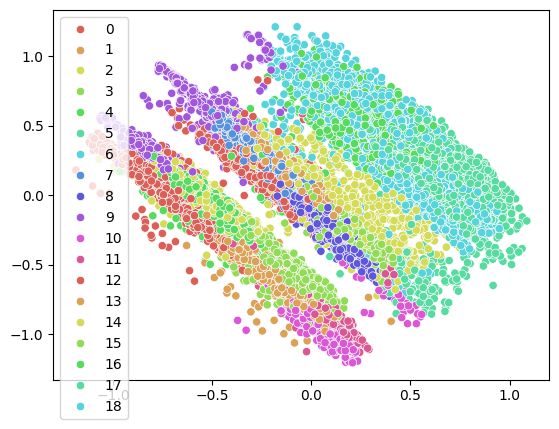

In [54]:
# Dla 19
pca = PCA()
kmeans = KMeans(n_clusters=19, random_state = seed)
result = pca.fit_transform(df_final)
labels = kmeans.fit_predict(df_final)
sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = labels, palette=sns.color_palette("hls", 12))
plt.show()

Dalsze wizualizacje nie beda miały sensu, jeśli robić to w ten sposób. Kolory się zapętlają. A jak to wygląda na mapce? Końcowo przecież o to nam chodzi

#### Mapka

In [90]:
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,license,rating,beds,baths,labels
4429,40.707610,-73.951330,0.333333,0.627116,0.126667,0.259209,0.270604,0.067837,0.000000,0.417926,0.0,0.064131,0.000000,0.578954,0
14759,40.715700,-73.776340,0.333333,0.424696,0.126667,0.191707,0.001553,0.043517,0.000000,0.000000,0.0,0.332455,0.000000,0.757568,0
14763,40.753310,-73.935010,0.666667,0.600504,0.000000,0.329124,0.042958,0.126989,0.802273,0.000000,0.0,0.130999,0.655415,0.578954,0
12221,40.738720,-73.897040,0.333333,0.370865,0.126667,0.486045,0.011791,0.266556,0.645558,0.000000,0.0,0.899515,0.000000,0.892098,0
12220,40.718590,-73.996950,1.000000,0.635846,0.126667,0.146097,0.331525,0.120011,0.000000,0.263895,0.0,1.000000,0.000000,0.578954,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,40.630420,-74.102990,0.333333,0.504643,0.024227,0.581102,0.981449,0.567698,0.000000,0.927566,1.0,0.570843,0.655415,0.578954,11
8446,40.608000,-74.007880,1.000000,0.732095,0.000000,0.146097,0.978826,0.740432,0.000000,0.945139,1.0,1.000000,0.655415,0.578954,11
4423,40.658410,-73.959420,0.333333,0.519532,0.017206,0.776634,0.997330,0.565932,0.000000,0.793897,1.0,0.861992,0.655415,0.578954,11
6139,40.661086,-73.897809,1.000000,0.575466,0.017206,0.430102,0.997330,0.667189,0.000000,0.989865,1.0,0.880570,0.655415,0.578954,11


In [86]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

In [96]:
# Dla 12 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=12, random_state = seed)
labels = kmeans.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# poprzez dwukrotne nacisniecie na kropke (szybkie) w labels mozemy zaznaczyc, zeby pokazywalo tylko jeden klaster
# Po krotkiej analizie stwierdzic mozna, ze to za malo klastrow

In [97]:
# Dla 19 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=19, random_state = seed)
labels = kmeans.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# Juz lepiej (np klaster 7), ale dalej te mieszkania sa rozrzucone po calym manhatanie

In [98]:
# Dla 29 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=29, random_state = seed)
labels = kmeans.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

#### Konkluzja

W naszej ramce wsm dalej mamy wiele w gruncie nie istotnych kolumn. Nie wiem czy da się ustawiać wagi do kolumn (żeby taki kmeans bral pod uwage bardziej longitude, latitude, rating i price pod uwage niz inne kolumny). Ale zawsze mozna przeciez zostawic najistotniejsze kolumny i sprawdzic co sie stanie. (No raczej powinno sie poprawic przynajmniej "na oko" (patrzac na mapke))

In [100]:
df.columns

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'license',
       'rating', 'beds', 'baths', 'labels'],
      dtype='object')

#### Zostawiajac najistotniejsze kolumny...

In [101]:
# Dla 12 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=12, random_state = seed)
# Przewiduje klastry na tylko istotnych kolumnach
labels = kmeans.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# Dalej za mało klastrów

In [102]:
# Dla 19 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=19, random_state = seed)
# Przewiduje klastry na tylko istotnych kolumnach
labels = kmeans.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

In [103]:
# Dla 29 klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=29, random_state = seed)
# Przewiduje klastry na tylko istotnych kolumnach
labels = kmeans.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# No ładniej sie robi (np wyłapało klaster 7)

In [106]:
# Dla 90? klastrów
# przewiduje kmeans i labele ustawiam
kmeans = KMeans(n_clusters=90, random_state = seed)
# Przewiduje klastry na tylko istotnych kolumnach
labels = kmeans.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# No nie wiem mi się tak podoba

Jeszcze z ciekawości zobaczmy jak zachowują się metryki jeżeli zostawimy tylko naistiotniejsze kolumny

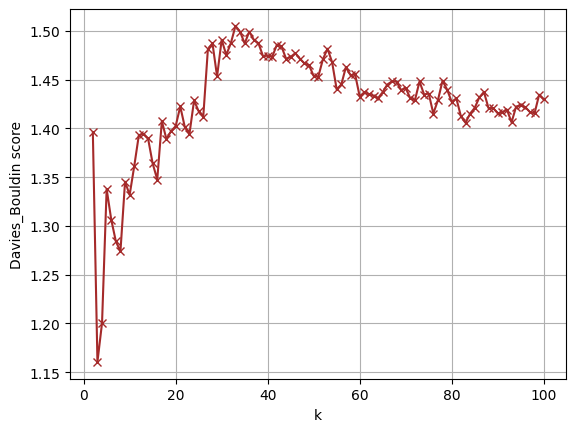

In [110]:
scores = []    
for k in range(2, 101):
    model_instance = KMeans(n_clusters=k, random_state = seed)
    labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
    wcss = davies_bouldin_score(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1), labels)
    scores.append(wcss)
plt.plot(range(2, 101), scores, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.grid()
plt.show()
# Rzeczywisie widac, ze jezeli chcemy duza liczbe klastrow to okolo 90 wydaje sie nie najgorszym pomyslem

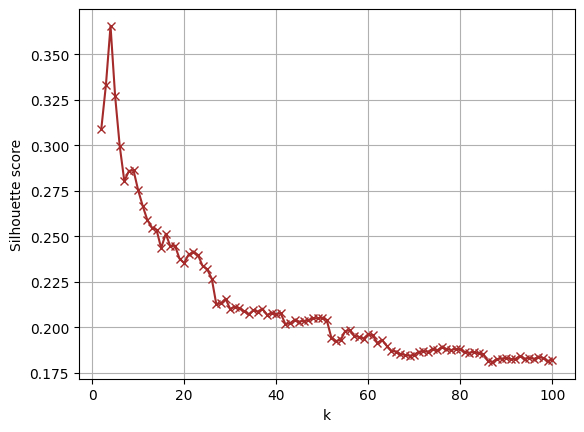

In [111]:
scores = []    
for k in range(2, 101):
    model_instance = KMeans(n_clusters=k, random_state = seed)
    labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
    wcss = silhouette_score(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1), labels)
    scores.append(wcss)
plt.plot(range(2, 101), scores, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()
# Ale nie jest juz tak wg tej metryki

## 2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [25]:
from sklearn.cluster import DBSCAN

### 2.1 strojenie parametrów

#### eps
odnosi się do maksymalnej odległości między dwoma punktami, które mogą być uznane za sąsiadów; wplywa na to ile punktow jest unzawanych za czesc klastra

Uzyjemy metody k-nearest neighbors (KNN)

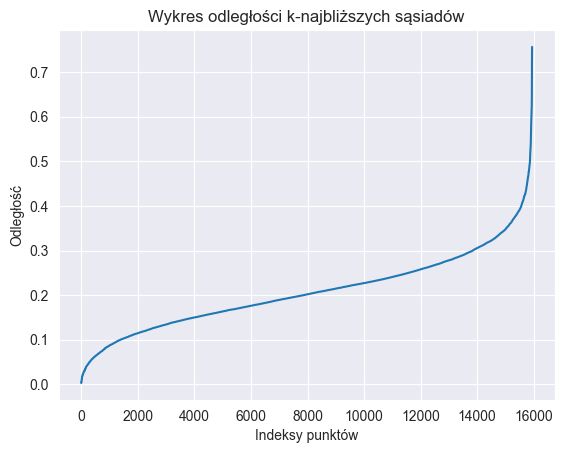

In [22]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_final)
distances, indices = nbrs.kneighbors(df_final)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.title("Wykres odległości k-najbliższych sąsiadów")
plt.xlabel("Indeksy punktów")
plt.ylabel("Odległość")
plt.show()

Szukamy punktu gdzie nastepuje nagly skok w odleglosciach (szybko rosnie do gory).

U na będzie to około między 0.3 a 0.4


#### min_samples
Określa minimalną liczbę punktów w sąsiedztwie punktu centralnego (core point).

Zazwyczaj jego wartość ustawia sie na wartosc wieksza niz wymiarowosc zbioru danych. 
Zatem, skoro nasz dane są 14-wymiarowe to min_samples powinno wynosic co najmniej 15.

#### strojenie

In [54]:
# UWAGA DLUGO SIE WYKONUJE - ok.18min
from sklearn.metrics import silhouette_score
# eps_values to 0.3, 0.35,0.4
eps_values = [0.3, 0.35, 0.4]
min_samples_values = np.arange(15, 25, 1)
best_score = -1
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_sample in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(df_final)
        # ignorowanie wynikow z jednym klastrem
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df_final, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_sample

print(f"Best score: {best_score}, eps: {best_eps}, min_samples: {best_min_samples}")

Best score: 0.0570646390603561, eps: 0.4, min_samples: 20


In [53]:
# UWAGA DLUGO SIE WYKONUJE - ok.18min
from sklearn.metrics import silhouette_score
# eps_values to 0.3-1 co 0.05
eps_values = np.arange(0.3, 1, 0.05)
min_samples_values = np.arange(15, 25, 1)
best_score = -1
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_sample in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(df_final)
       # ignorowanie wynikow z jednym klastrem
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df_final, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_sample

print(f"Best score: {best_score}, eps: {best_eps}, min_samples: {best_min_samples}")

Best score: 0.2335570384327045, eps: 0.8999999999999999, min_samples: 15


Co ciekawe gdy patrzymy na przedziale eps 0.3-0.4 (czyli takim jaki powinien byc wedlug wyznaczania eps metoda KNN) to najlpeszy wynik (wg silhouette score) jest dla eps=0.4 min_samples=20 - wynik: 0.057064

jednak dla wiekszych przedziałow (gdy patrzymy juz do 1), najlepszy wynik wychodzi dla eps=0.8, min_samples=15 - wynik: 0.23355704

Dlatego sprawdzimy oba te wyniki

### 2.2 model

In [55]:
# dla eps=0.4
dbscan_eps_4 = DBSCAN(eps=0.4, min_samples=20)
clusters_dbscan_4 = dbscan_eps_4.fit_predict(df_final)

# dla eps=.8
dbscan_eps_8 = DBSCAN(eps=0.8, min_samples=15)
clusters_dbscan_8 = dbscan_eps_8.fit_predict(df_final)

### 2.3 wyniki

#### wskaznik Silhouette

In [56]:
from sklearn.metrics import silhouette_score

score_4 = silhouette_score(df_final, clusters_dbscan_4)
score_8 = silhouette_score(df_final, clusters_dbscan_8)

print(f"Silhouette score dla eps=0.4 i min_smaples=8: {score_4}")
print(f"Silhouette score dla eps=0.8 i min_smaples=3: {score_8}")

Silhouette score dla eps=0.4 i min_smaples=8: 0.0570646390603561
Silhouette score dla eps=0.8 i min_smaples=3: 0.193179172139691


ewidentnie widizmy tu ze dla eps=0.8, min_samples=3 wynik jest lepszy

#### wizualizacja

In [58]:
from sklearn.decomposition import PCA
pca = PCA()
result = pca.fit_transform(df_final)

Dla eps=0.4 i min_samples=20

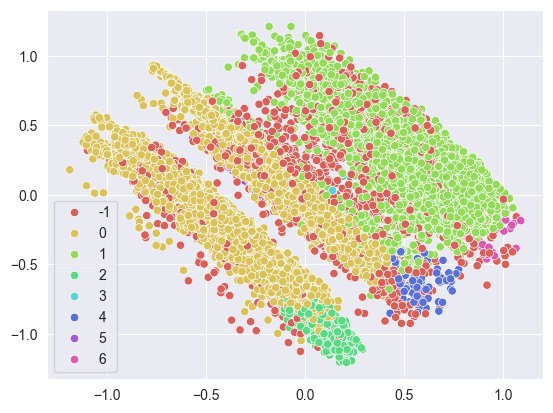

In [62]:
sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = clusters_dbscan_4[:], palette=sns.color_palette("hls", 8))
plt.show()

Dla eps=0.8 i min_samples=15

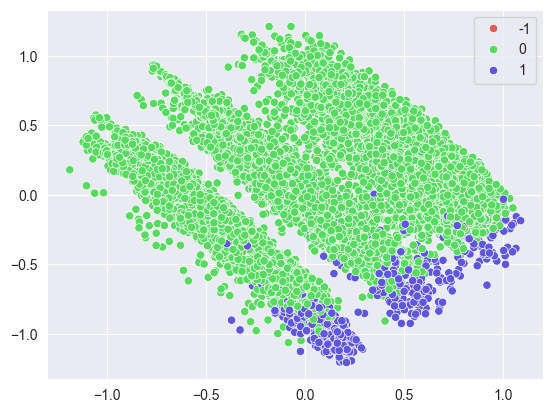

In [63]:
sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = clusters_dbscan_8[:], palette=sns.color_palette("hls", 3))
plt.show()

#### indeks Daviesa-Bouldina
Niskie wartości tego indeksu sugerują lepsze klastrowanie, co oznacza, że klastry są dobrze oddzielone i mają niską wariancję wewnętrzną.

In [57]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score_4 = davies_bouldin_score(df_final, clusters_dbscan_4)
davies_bouldin_score_8 = davies_bouldin_score(df_final, clusters_dbscan_8)

print(f"Indeks Daviesa-Bouldina dla eps=0.4 i min_smaples=20: {davies_bouldin_score_4}")
print(f"Indeks Daviesa-Bouldina dla eps=0.8 i min_smaples=15: {davies_bouldin_score_8}")

Indeks Daviesa-Bouldina dla eps=0.4 i min_smaples=8: 2.008856764154024
Indeks Daviesa-Bouldina dla eps=0.8 i min_smaples=3: 1.9062054177808954


Wynik dla eps=0.8, min_samples=3 jest lepszy -> czyli tak samo jak w shilouette score

## 3. Klasteryzacja hierarchiczna

In [128]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.ticker import MaxNLocator

### 3.1 Davies_Bouldin score

In [ ]:
# porównajmy wyniki z tymi z kmeans

In [135]:
linkages = ['ward', 'complete', 'average', 'single']

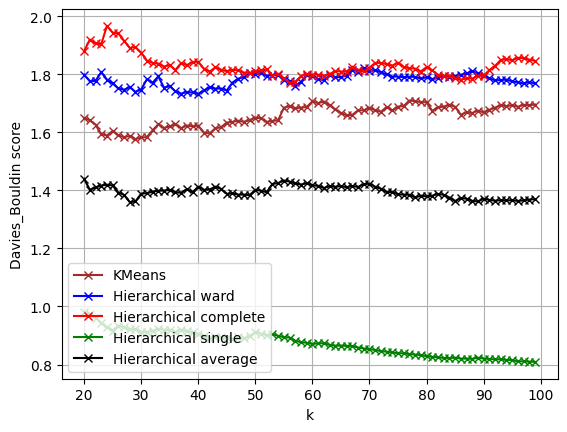

In [136]:
# UWAGA NIE WYKONYWAC TEJ KOMORKI (robi się bardzo długo) (ponad godzina)
cluster_num_seq = range(20, 100)
davies_vec_kmeans = count_clustering_scores(df_final, cluster_num_seq, KMeans, davies_bouldin_score)
davies_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(df_final)
        wcss = davies_bouldin_score(df_final, labels)
        davies_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, davies_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, davies_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, davies_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, davies_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, davies_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output.jpg")
plt.show()

Jak widać single linkage deklasuje resztę w tej metryce. Pytanie czy to oznacza, że ogólnie jest lepszy.  
Dla silhouette_score nawet nie będę patrzył, chyba, że na noc zostawię komputer

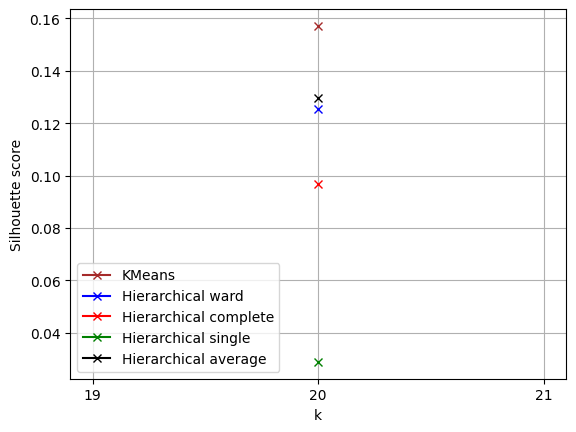

In [138]:
# silhouette_score (Zostawic na noc)
cluster_num_seq = range(20, 100)
silhouette_vec_kmeans = count_clustering_scores(df_final, cluster_num_seq, KMeans, silhouette_score)
silhouette_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(df_final)
        wcss = silhouette_score(df_final, labels)
        silhouette_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, silhouette_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output2.jpg")
plt.show()

Dobra to zobaczmy jak radzić sobie będą teraz różne linkage na mapkach

### 3.2 Mapki

#### 3.2.1 30 klastrów

In [141]:
n_clusters = 30

##### Single (wszystkie kolumny)

In [144]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
labels = model_instance.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# Zbyt duże różnice w wielkości klastrów

##### Single (istotne kolumny)

In [145]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# Również słabo, że niektóre klastry są bardzo małe

##### Average (wszystkie kolumny)

In [147]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
labels = model_instance.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()
# Zbyt duże różnice w wielkości klastrów (dalej)

##### Average (istotniejsze kolumny)

In [148]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

##### Complete (wszystkie kolumny)

In [150]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

##### Complete (istotniejsze kolumny)

In [151]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

##### Ward (wszystkie kolumny)

In [152]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final)
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

##### Ward (istotniejsze kolumny)

In [153]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

#### 3.2.2 90 klastrów

##### WARD (istotniejsze kolumny) 

In [154]:
# przewiduje kmeans i labele ustawiam
model_instance = AgglomerativeClustering(n_clusters=90, linkage='ward')
# Przewiduje klastry na tylko istotnych kolumnach
labels = model_instance.fit_predict(df_final.drop(['minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'license', 'baths'], axis = 1))
df = df_final.copy()
df['labels'] = labels
df.sort_values(by=['labels'], axis = 0, inplace = True)
df['labels'] = df['labels'].astype(np.str_)
# odwracam min max scaling
df['latitude'] = df['latitude'] * (lat_max - lat_min) + lat_min
df['longitude'] = df['longitude'] * (long_max - long_min) + long_min
# plot
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude", color="labels",
                    zoom=10, height=800, hover_data = ['price', 'rating'])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()